In [23]:
import pandas as pd

# Load your data
file_path = 'section_3.csv'
with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
    df = pd.read_csv(f)

# Extract user IDs and text data
user_ids = df['Id']  
text_data1 = df['Please specify your broad areas of interest (keywords only) for the final project (e.g., games, reinforcement learning, computer vision, natural language processing, etc.) in ranked order of preferenc'] 
text_data2 = df['Do you already have one or more specific project ideas? If so, please briefly describe them.�']  # Replace with the actual name of the second text column
text_data2 = text_data2.fillna('')
# Combine the two text columns (you can concatenate them, or choose a different method)
combined_text = text_data1 + " " + text_data2






In [24]:
combined_text[:5]

0    1 Natural language processing \n2 Models  - Mu...
1    Natural Language Processing, Reinforcement Lea...
2    Computer vision, recommendations, optimization...
3    Machine learning\nNatural language processing ...
4    Reinforcement Learning\n\nComputer Vision\n\nG...
dtype: object

In [25]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-nli-mean-tokens')

embeddings = model.encode(combined_text.tolist(), show_progress_bar=True)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [26]:
import pandas as pd
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from collections import defaultdict

max_size = 4

In [27]:
# # Function to perform clustering and handle clusters larger than the max size
# def recluster_large_clusters(cluster_dict, embeddings, max_size=4):
#     final_clusters = []
    
#     for cluster_items in cluster_dict.values():
#         # If a cluster is larger than the max size, split it further using KMeans
#         if len(cluster_items) > max_size:
#             sub_embeddings = [embeddings[i] for i in cluster_items]
            
#             # Create a new KMeans model to split large clusters into smaller ones
#             sub_kmeans = KMeans(n_clusters=(len(cluster_items) // max_size) + 1, random_state=0)
#             sub_labels = sub_kmeans.fit_predict(sub_embeddings)
            
#             # Group the sub-clustered items
#             sub_cluster_dict = defaultdict(list)
#             for idx, sub_label in zip(cluster_items, sub_labels):
#                 sub_cluster_dict[sub_label].append(idx)
                
#             # Add the sub-clusters to the final list
#             for sub_cluster_items in sub_cluster_dict.values():
#                 final_clusters.append(sub_cluster_items)
#         else:
#             # If cluster size is within the limit, add it as-is
#             final_clusters.append(cluster_items)
    
#     return final_clusters

In [28]:
from sklearn.cluster import KMeans
from collections import defaultdict

# Function to perform clustering and handle clusters larger than the max size
def recluster_large_clusters(cluster_dict, embeddings, max_size=4):
    final_clusters = []
    
    for cluster_items in cluster_dict.values():
        # If a cluster is larger than the max size, split it further using KMeans
        if len(cluster_items) > max_size:
            # Get embeddings for items in this cluster
            sub_embeddings = [embeddings[i] for i in cluster_items]
            
            # Determine the number of sub-clusters needed
            n_sub_clusters = (len(cluster_items) // max_size) + 1
            
            # Create and fit KMeans to split the large cluster
            sub_kmeans = KMeans(n_clusters=n_sub_clusters, random_state=0)
            sub_labels = sub_kmeans.fit_predict(sub_embeddings)
            
            # Group items by sub-cluster label
            sub_cluster_dict = defaultdict(list)
            for idx, sub_label in zip(cluster_items, sub_labels):
                sub_cluster_dict[sub_label].append(idx)
                
            # Add each sub-cluster to final_clusters, ensuring they meet size requirements
            for sub_cluster_items in sub_cluster_dict.values():
                if len(sub_cluster_items) > max_size:
                    # Recursively split sub-clusters that still exceed max_size
                    split_sub_clusters = recluster_large_clusters({0: sub_cluster_items}, embeddings, max_size)
                    final_clusters.extend(split_sub_clusters)
                else:
                    final_clusters.append(sub_cluster_items)
        else:
            # If the cluster size is within the limit, add it as-is
            final_clusters.append(cluster_items)
    
    return final_clusters

In [29]:

# # Function to combine clusters with fewer than 4 members
# def combine_small_clusters(clusters, embeddings, max_size=4):
#     # Identify clusters with fewer than 4 members
#     small_clusters = [cluster for cluster in clusters if len(cluster) < max_size]
#     remaining_clusters = [cluster for cluster in clusters if len(cluster) == max_size]

#     combined = False  # Track if any clusters are combined
#     new_clusters = remaining_clusters.copy()

#     # For each small cluster, find the most similar cluster and merge
#     for small_cluster in small_clusters:
#         small_embeddings = np.mean([embeddings[i] for i in small_cluster], axis=0)

#         # Find the nearest cluster that still has space to accommodate the small cluster
#         min_distance = float('inf')
#         nearest_cluster = None
#         nearest_cluster_idx = -1
#         for idx, cluster in enumerate(new_clusters):
#             if len(cluster) < max_size:  # Only consider clusters with space
#                 cluster_embeddings = np.mean([embeddings[i] for i in cluster], axis=0)
#                 distance = euclidean_distances([small_embeddings], [cluster_embeddings])[0][0]
#                 if distance < min_distance:
#                     min_distance = distance
#                     nearest_cluster = cluster
#                     nearest_cluster_idx = idx

#         # Merge small cluster with the nearest cluster (but ensure combined cluster does not exceed 4 members)
#         if nearest_cluster is not None and len(small_cluster) + len(nearest_cluster) <= max_size:
#             new_clusters[nearest_cluster_idx].extend(small_cluster)
#             combined = True
#         else:
#             # If no valid merge is found, leave the small cluster as a new independent cluster
#             new_clusters.append(small_cluster)

#     return new_clusters, combined

In [30]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

# Function to combine clusters with fewer than max_size members
def combine_small_clusters(clusters, embeddings, max_size=4):
    # Identify clusters with fewer than max_size members
    small_clusters = [cluster for cluster in clusters if len(cluster) < max_size]
    remaining_clusters = [cluster for cluster in clusters if len(cluster) == max_size]

    combined = False  # Track if any clusters are combined
    new_clusters = remaining_clusters.copy()

    # For each small cluster, find the most similar cluster to merge with
    for small_cluster in small_clusters:
        # Calculate the centroid of the small cluster
        small_centroid = np.mean([embeddings[i] for i in small_cluster], axis=0)

        # Find the nearest cluster with space available
        min_distance = float('inf')
        nearest_cluster = None
        nearest_cluster_idx = -1

        for idx, cluster in enumerate(new_clusters):
            if len(cluster) < max_size:  # Only consider clusters with available space
                cluster_centroid = np.mean([embeddings[i] for i in cluster], axis=0)
                distance = euclidean_distances([small_centroid], [cluster_centroid])[0][0]
                if distance < min_distance:
                    min_distance = distance
                    nearest_cluster = cluster
                    nearest_cluster_idx = idx

        # Merge small cluster with the nearest cluster (ensuring max_size limit)
        if nearest_cluster is not None and len(small_cluster) + len(nearest_cluster) <= max_size:
            new_clusters[nearest_cluster_idx].extend(small_cluster)
            combined = True
        else:
            # If no valid merge is found, add the small cluster as a new independent cluster
            new_clusters.append(small_cluster)

    return new_clusters, combined

In [31]:
# Generate embeddings for the combined text data
embeddings = model.encode(combined_text.tolist(), show_progress_bar=True)

# Perform initial clustering with KMeans
initial_num_clusters = len(combined_text) // max_size
kmeans = KMeans(n_clusters=initial_num_clusters, random_state=0)
initial_labels = kmeans.fit_predict(embeddings)

# Group items by their initial cluster labels
cluster_dict = defaultdict(list)
for i, label in enumerate(initial_labels):
    cluster_dict[label].append(i)

# Perform iterative clustering inside a loop
iteration_count = 0  # Add an iteration counter to prevent infinite loops
max_iterations = 50  # Set a maximum number of iterations to avoid infinite loops

while iteration_count < max_iterations:
    iteration_count += 1
    
    # Re-cluster large clusters
    new_clusters = recluster_large_clusters(cluster_dict, embeddings, max_size=max_size)
    print(f"New clusters after reclustering (Iteration {iteration_count}):")
    for i, cluster in enumerate(new_clusters):
        print(f"Cluster {i} size: {len(cluster)}")

    # Combine small clusters with their nearest neighbors
    final_clusters, combined = combine_small_clusters(new_clusters, embeddings, max_size=max_size)
    
    print(f"Final clusters after combining (Iteration {iteration_count}):")
    for i, cluster in enumerate(final_clusters):
        print(f"Cluster {i} size: {len(cluster)}")

    # Debug: Print the sizes of all clusters after each iteration
    print(f"Iteration {iteration_count} cluster sizes: {[len(c) for c in final_clusters]}")
    
    # Check if all clusters are now size 4
    if all(len(cluster) == max_size for cluster in final_clusters):
        break  # Exit the loop if all clusters have exactly 4 members
    
    # If no changes were made, stop the loop to avoid infinite looping
    if not combined:
        print("No further changes detected, stopping iteration.")
        break

    # Update cluster_dict for the next iteration
    cluster_dict = defaultdict(list)
    for i, cluster in enumerate(final_clusters):
        for item in cluster:
            cluster_dict[i].append(item)

# Flatten the clusters and assign final labels
final_cluster_labels = np.zeros(len(combined_text), dtype=int)

# **Fix for Label Assignment**
# Ensure that each cluster gets a unique ID and all points are labeled correctly
for cluster_id, cluster_items in enumerate(final_clusters):
    for item in cluster_items:
        final_cluster_labels[item] = cluster_id

# Add the new cluster labels to the DataFrame
df['cluster'] = final_cluster_labels

# Debug: Check the cluster assignment
print("Cluster label assignment complete.")
print(df[['Id', 'cluster']].head())  # Display the first few rows with cluster labels

# Sort the DataFrame by cluster labels
df_sorted = df.sort_values(by='cluster')

# Save the sorted DataFrame to a new CSV file
df_sorted.to_csv('result_3/K-Means_llm.csv', index=False)

print("Clustering completed with exactly 4 members per cluster and saved to final_balanced_clusters.csv")


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

New clusters after reclustering (Iteration 1):
Cluster 0 size: 1
Cluster 1 size: 4
Cluster 2 size: 4
Cluster 3 size: 2
Cluster 4 size: 1
Cluster 5 size: 4
Cluster 6 size: 1
Cluster 7 size: 1
Cluster 8 size: 1
Cluster 9 size: 3
Cluster 10 size: 4
Cluster 11 size: 2
Cluster 12 size: 1
Cluster 13 size: 1
Cluster 14 size: 1
Cluster 15 size: 3
Cluster 16 size: 2
Cluster 17 size: 1
Cluster 18 size: 2
Cluster 19 size: 2
Cluster 20 size: 3
Cluster 21 size: 2
Cluster 22 size: 3
Cluster 23 size: 1
Cluster 24 size: 2
Cluster 25 size: 1
Cluster 26 size: 3
Cluster 27 size: 2
Cluster 28 size: 2
Cluster 29 size: 3
Cluster 30 size: 4
Cluster 31 size: 1
Cluster 32 size: 3
Cluster 33 size: 3
Cluster 34 size: 3
Cluster 35 size: 2
Cluster 36 size: 2
Cluster 37 size: 4
Cluster 38 size: 2
Cluster 39 size: 1
Cluster 40 size: 1
Cluster 41 size: 2
Cluster 42 size: 2
Cluster 43 size: 1
Cluster 44 size: 3
Cluster 45 size: 2
Cluster 46 size: 2
Cluster 47 size: 2
Final clusters after combining (Iteration 1):
Clust

In [32]:
import numpy as np
from cluster_quality_metrics import (
    within_cluster_sum_of_squares,
    average_pairwise_similarity,
    inter_cluster_distance,
    overall_average_pairwise_similarity,
    plot_wcss,
    plot_cohesion,
    plot_separation
)


WCSS per cluster: {0: 188.19289, 1: 90.64643, 2: 20.38335, 3: 53.706062, 4: 187.12411, 5: 275.37042, 6: 171.93243, 7: 124.13845, 8: 105.807205, 9: 328.999, 10: 256.47162, 11: 171.08115, 12: 136.64877, 13: 58.63952, 14: 190.46957, 15: 88.92108, 16: 26.793997, 17: 113.340515, 18: 196.63629, 19: 107.43191, 20: 45.85733, 21: 63.296505, 22: 119.48241, 23: 46.794872, 24: 204.26463, 25: 163.31693, 26: 40.82291, 27: 75.16066, 28: 128.9924, 29: 49.69706, 30: 95.11239}


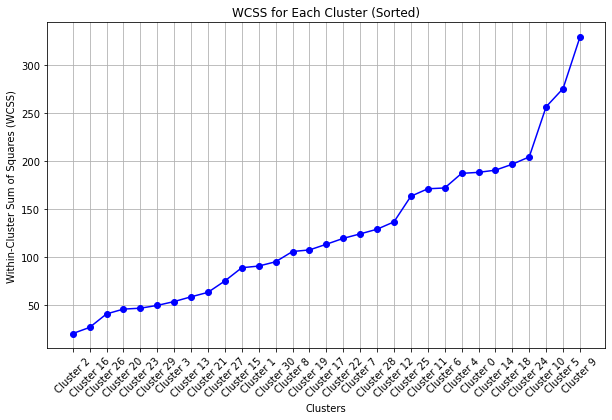

Cohesion per cluster: {0: 0.76419574, 1: 0.88482445, 2: 0.9748742, 3: 0.93443006, 4: 0.7571268, 5: 0.60853976, 6: 0.7690532, 7: 0.83666086, 8: 0.86260253, 9: 0.5370324, 10: 0.65698665, 11: 0.77403384, 12: 0.83372825, 13: 0.9251723, 14: 0.75251395, 15: 0.8221512, 16: 0.9517603, 17: 0.7894346, 18: 0.60015213, 19: 0.7812955, 20: 0.91331154, 21: 0.8703491, 22: 0.74355525, 23: 0.7814883, 24: 0.58568054, 25: 0.64905566, 26: 0.82573366, 27: 0.69148546, 28: 0.7505796, 29: 0.79805595, 30: 0.65557426}


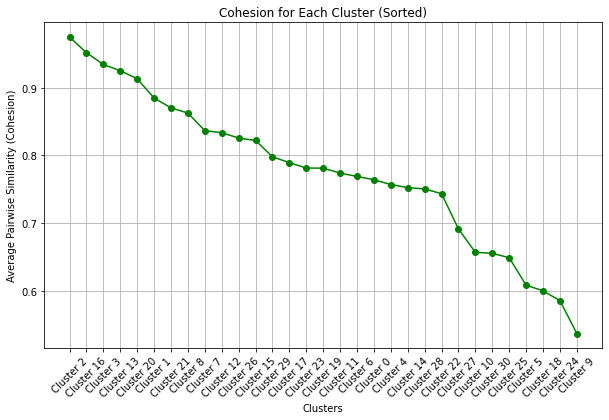

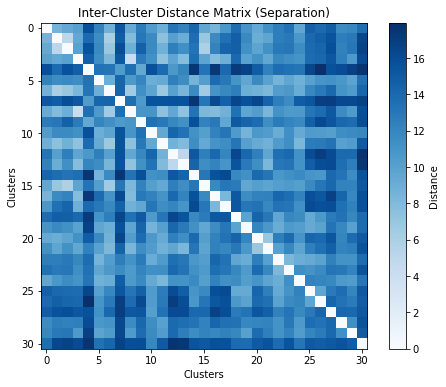

Overall Average Pairwise Similarity: 0.7840231568552554


In [ ]:
embeddings_np = np.array(embeddings)
# Calculate WCSS and plot
wcss_per_cluster = within_cluster_sum_of_squares(embeddings_np, final_clusters)
print("WCSS per cluster:", wcss_per_cluster)
plot_wcss(wcss_per_cluster)


# Calculate Cohesion and plot
cohesion_per_cluster = average_pairwise_similarity(embeddings, final_clusters)
print("Cohesion per cluster:", cohesion_per_cluster)
plot_cohesion(cohesion_per_cluster)

# Calculate Inter-Cluster Distance (Separation) and plot
separation_matrix = inter_cluster_distance(embeddings, final_clusters)
# print("Inter-Cluster Distance Matrix:\n", separation_matrix)
plot_separation(separation_matrix)

# Calculate Overall Average Pairwise Similarity
overall_similarity = overall_average_pairwise_similarity(embeddings, final_clusters)
print("Overall Average Pairwise Similarity:", overall_similarity)

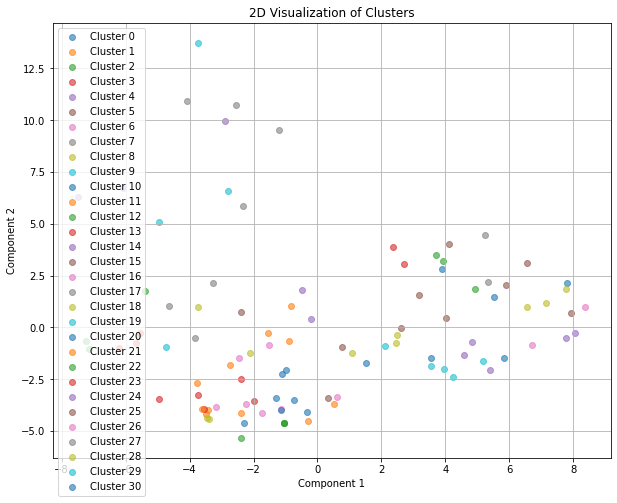

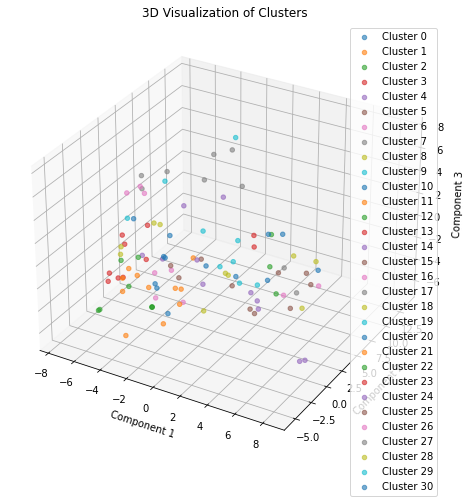

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # Only needed for 3D plotting

def plot_clusters_2d(embeddings, labels):
    # Reduce dimensions to 2D using PCA or t-SNE
    reduced_embeddings = PCA(n_components=2).fit_transform(embeddings)
    # Alternatively, use t-SNE if PCA doesn’t capture enough variance
    # reduced_embeddings = TSNE(n_components=2, perplexity=30).fit_transform(embeddings)
    
    # Scatter plot with colors for each cluster
    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        plt.scatter(
            reduced_embeddings[labels == label, 0],
            reduced_embeddings[labels == label, 1],
            label=f'Cluster {label}',
            alpha=0.6
        )
    plt.title('2D Visualization of Clusters')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_clusters_3d(embeddings, labels):
    # Reduce dimensions to 3D using PCA or t-SNE
    reduced_embeddings = PCA(n_components=3).fit_transform(embeddings)
    # Alternatively, use t-SNE for non-linear dimensionality reduction
    # reduced_embeddings = TSNE(n_components=3, perplexity=30).fit_transform(embeddings)
    
    # 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    unique_labels = np.unique(labels)
    for label in unique_labels:
        ax.scatter(
            reduced_embeddings[labels == label, 0],
            reduced_embeddings[labels == label, 1],
            reduced_embeddings[labels == label, 2],
            label=f'Cluster {label}',
            alpha=0.6
        )
    ax.set_title('3D Visualization of Clusters')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    ax.legend()
    plt.show()

# Example usage
# Assuming embeddings is a 2D array of your high-dimensional data and labels is an array of cluster labels
plot_clusters_2d(embeddings, final_cluster_labels)  # 2D plot
plot_clusters_3d(embeddings, final_cluster_labels)  # 3D plot


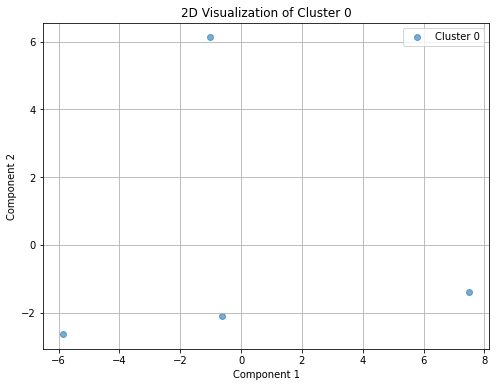

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_single_cluster(embeddings, labels, target_cluster=0):
    """
    Plot only a single cluster in 2D after reducing the dimensionality.
    
    Args:
        embeddings (np.array): High-dimensional data points (e.g., embeddings).
        labels (np.array): Cluster labels for each data point.
        target_cluster (int): The cluster to plot.
    """
    # Filter embeddings for the target cluster
    cluster_embeddings = embeddings[labels == target_cluster]
    
    # Reduce dimensions to 2D using PCA or t-SNE
    reduced_embeddings = PCA(n_components=2).fit_transform(cluster_embeddings)
    # Alternatively, use t-SNE if you prefer non-linear dimensionality reduction
    # reduced_embeddings = TSNE(n_components=2, perplexity=30).fit_transform(cluster_embeddings)

    # Scatter plot for the target cluster
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.6, label=f'Cluster {target_cluster}')
    plt.title(f'2D Visualization of Cluster {target_cluster}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
# Assuming embeddings is a 2D array of your high-dimensional data and labels is an array of cluster labels
plot_single_cluster(embeddings, final_cluster_labels, target_cluster=0)  # Plot only Cluster 0


In [36]:
# Assuming 'df' is defined with 'Id' and 'cluster' columns after clustering

# Group Ids by cluster and convert each group's Ids to a list
clustered_ids = df.groupby('cluster')['Id'].apply(list)

print("Cluster assignment complete. Ids for each cluster:")
for cluster_id, ids in clustered_ids.items():
    print(f"Cluster {cluster_id}: {ids}")  # Print each cluster's Ids as an array


Cluster assignment complete. Ids for each cluster:
Cluster 0: [47, 117, 127, 207]
Cluster 1: [46, 57, 211, 235]
Cluster 2: [193, 248, 249, 251]
Cluster 3: [49, 53, 58, 331]
Cluster 4: [76, 150, 181, 332]
Cluster 5: [100, 112, 215, 236]
Cluster 6: [43, 122, 203, 228]
Cluster 7: [48, 50, 129, 209]
Cluster 8: [89, 106, 119, 144]
Cluster 9: [140, 245, 252, 327]
Cluster 10: [54, 67, 78, 82]
Cluster 11: [118, 131, 237, 314]
Cluster 12: [55, 124, 210, 325]
Cluster 13: [134, 167, 198, 329]
Cluster 14: [71, 288, 304, 306]
Cluster 15: [201, 250, 263]
Cluster 16: [51, 291, 305]
Cluster 17: [123, 231, 244]
Cluster 18: [64, 148, 191]
Cluster 19: [99, 163, 168]
Cluster 20: [77, 90, 165]
Cluster 21: [143, 154, 218]
Cluster 22: [98, 151, 232]
Cluster 23: [120, 137]
Cluster 24: [196, 286, 303]
Cluster 25: [107, 108, 114]
Cluster 26: [145, 240]
Cluster 27: [146, 174]
Cluster 28: [230, 313, 320]
Cluster 29: [239, 255]
Cluster 30: [309, 333]
